**Environment Setup, Data Loading and Initial Exploration**

In [4]:
# === Section 1: Environment Setup, Data Loading, and Initial Exploration ===
!pip install --quiet xgboost==1.7.6 tensorflow==2.15.0 econml==0.13.0 ortools==9.9.1875

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/MLBA/amazon_products_sales_data_cleaned.csv'
data = pd.read_csv(file_path)

# Quick check
print(f"Dataset loaded successfully. Shape: {data.shape}")
display(data.head(10))
data.info()

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
Mounted at /content/drive
Dataset loaded successfully. Shape: (42675, 15)


,product_title,product_rating,total_reviews,purchased_last_month,discounted_price,original_price,is_best_seller,is_sponsored,has_coupon,buy_box_availability,delivery_date,sustainability_tags,data_collected_at,product_category,discount_percentage
0,BOYA BOYALINK 2 Wireless Lavalier Microphone f...,4.6,375.0,300.0,89.68,159.00,No Badge,Sponsored,Save 15% with coupon,Add to cart,01-09-2025,Carbon impact,21-08-2025 11:14,Phones,43.60
1,"LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...",4.3,2457.0,6000.0,9.99,15.99,No Badge,Sponsored,No Coupon,Add to cart,29-08-2025,NaN,21-08-2025 11:14,Laptops,37.52
2,"DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...",4.6,3044.0,2000.0,314.00,349.00,No Badge,Sponsored,No Coupon,Add to cart,01-09-2025,NaN,21-08-2025 11:14,Laptops,10.03
3,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",4.6,35882.0,10000.0,162.24,162.24,Best Seller,Organic,No Coupon,NaN,NaN,NaN,21-08-2025 11:14,Phones,0.00
4,Apple AirTag 4 Pack. Keep Track of and find Yo...,4.8,28988.0,10000.0,72.74,72.74,No Badge,Organic,No Coupon,NaN,NaN,NaN,21-08-2025 11:14,Phones,0.00
5,Texas Instruments TI-84 Plus CE Color Graphing...,4.6,44522.0,100000.0,99.95,99.95,Best Seller,Organic,No Coupon,NaN,NaN,NaN,21-08-2025 11:14,Other Electronics,0.00
6,"Apple AirPods 4 Wireless Earbuds, Bluetooth He...",4.5,13466.0,10000.0,88.11,88.11,No Badge,Organic,No Coupon,NaN,NaN,NaN,21-08-2025 11:14,Phones,0.00
7,Apple AirTag. Keep Track of and find Your Keys...,4.6,38105.0,10000.0,23.04,23.04,Best Seller,Organic,No Coupon,NaN,NaN,NaN,21-08-2025 11:14,Phones,0.00
8,Complete Protect: One plan covers all eligible...,4.0,4380.0,NaN,16.99,16.99,No Badge,Organic,Save 50% with coupon,NaN,NaN,NaN,21-08-2025 11:14,Other Electronics,0.00
9,"Apple iPad 11-inch: A16 chip, 11-inch Model, L...",4.7,7308.0,10000.0,284.05,284.05,Best Seller,Organic,No Coupon,NaN,NaN,Energy efficiency,21-08-2025 11:14,Cameras,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42675 entries, 0 to 42674
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_title         42675 non-null  object 
 1   product_rating        41651 non-null  float64
 2   total_reviews         41651 non-null  float64
 3   purchased_last_month  32164 non-null  float64
 4   discounted_price      40613 non-null  float64
 5   original_price        40613 non-null  float64
 6   is_best_seller        42675 non-null  object 
 7   is_sponsored          42675 non-null  object 
 8   has_coupon            42675 non-null  object 
 9   buy_box_availability  28022 non-null  object 
 10  delivery_date         30692 non-null  object 
 11  sustainability_tags   3408 non-null   object 
 12  data_collected_at     42675 non-null  object 
 13  product_category      42675 non-null  object 
 14  discount_percentage   40613 non-null  float64
dtypes: float64(6), obje

**Data Preprocessing and Feature Engineering**

In [5]:
# === Section: Data Preprocessing & Feature Engineering (corrected) ===
import os, pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

os.makedirs('outputs', exist_ok=True)

# Required columns
required_cols = ['discounted_price','product_rating','discount_percentage',
                 'data_collected_at','product_category','purchased_last_month']
missing = [c for c in required_cols if c not in data.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# 1) Drop rows with missing *critical* values (report how many)
before = data.shape[0]
data = data.dropna(subset=['discounted_price', 'product_rating', 'discount_percentage'])
print(f"Dropped {before - data.shape[0]} rows due to missing critical values")

# 2) Parse dates robustly and warn
date_col = 'data_collected_at'
data[date_col] = pd.to_datetime(data[date_col], errors='coerce', infer_datetime_format=True)
n_date_missing = data[date_col].isna().sum()
if n_date_missing > 0:
    print(f"Warning: {n_date_missing} rows have invalid {date_col} (inspect formatting).")

# 3) Remove duplicates
data = data.drop_duplicates()

# 4) Basic feature engineering
data['discount_flag'] = (data['discount_percentage'].fillna(0) > 0).astype(int)
data['price_log'] = np.log1p(data['discounted_price'].astype(float))
data['rating_scaled'] = data['product_rating'].astype(float) / 5.0

# normalize and extract timeparts
data = data.sort_values(date_col).reset_index(drop=True)
data['year'] = data[date_col].dt.year
data['month'] = data[date_col].dt.month
data['day'] = data[date_col].dt.day
data['weekday'] = data[date_col].dt.weekday

# 5) Encode category with persistence
cat_col = 'product_category'
le = LabelEncoder()
data[cat_col] = data[cat_col].astype(str).fillna('UNKNOWN')
data['category_encoded'] = le.fit_transform(data[cat_col])
with open(os.path.join('outputs','labelencoder_category.pkl'), 'wb') as f:
    pickle.dump(le, f)

# 6) Clean boolean/text flags robustly (safe when column absent)
def is_best_seller_fn(x):
    if pd.isna(x): return 0
    s = str(x).strip().lower()
    return 1 if ('best' in s and 'seller' in s) or (s in ('y','yes','true','1')) else 0

if 'is_best_seller' in data.columns:
    data['is_best_seller_bin'] = data['is_best_seller'].apply(is_best_seller_fn)
else:
    data['is_best_seller_bin'] = 0

def has_coupon_fn(x):
    if pd.isna(x): return 0
    s = str(x).lower()
    return 1 if ('save' in s or 'coupon' in s or 'offer' in s) else 0

if 'has_coupon' in data.columns:
    data['has_coupon_bin'] = data['has_coupon'].apply(has_coupon_fn)
else:
    data['has_coupon_bin'] = 0

# 7) Product-level lags (group by product_id if available)
group_col = 'product_id' if 'product_id' in data.columns else 'category_encoded'
if group_col == 'category_encoded':
    print("WARNING: 'product_id' not found — using category-level grouping (weaker).")

# ensure sort within each group by date
data = data.sort_values([group_col, date_col]).reset_index(drop=True)

# create lags for the target (do NOT fill with 0 blindly)
for lag in (1,2):
    lag_col = f'purchased_last_month_lag_{lag}'
    data[lag_col] = data.groupby(group_col)['purchased_last_month'].shift(lag)

# Option A: drop rows with NaN lag_1 (clean)
n_before = data.shape[0]
data = data.dropna(subset=[f'purchased_last_month_lag_1']).reset_index(drop=True)
dropped_lag_rows = n_before - data.shape[0]
print(f"Dropped {dropped_lag_rows} rows because they lack lag_1 (initial periods)")

# (Optional) Record this in a small data_card for reporting
data_card = {
    'n_rows_after_preproc': int(data.shape[0]),
    'n_cols_after_preproc': int(data.shape[1]),
    'dropped_initial_lag_rows': int(dropped_lag_rows),
    'date_col': date_col,
    'group_col': group_col
}
with open(os.path.join('outputs','data_card_preproc.json'),'w') as f:
    import json
    json.dump(data_card, f, indent=2)

print(f"Data shape after preprocessing: {data.shape}")
print("New features created:", [
    'discount_flag','price_log','rating_scaled','year','month','day','weekday',
    'category_encoded','is_best_seller_bin','has_coupon_bin',
    'purchased_last_month_lag_1','purchased_last_month_lag_2'
])
display(data.head(20))

Dropped 3085 rows due to missing critical values


/tmp/ipython-input-3301341888.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data[date_col] = pd.to_datetime(data[date_col], errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-3301341888.py:23: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[date_col] = pd.to_datetime(data[date_col], errors='coerce', infer_datetime_format=True)


Dropped 4854 rows because they lack lag_1 (initial periods)
Data shape after preprocessing: (17571, 27)
New features created: ['discount_flag', 'price_log', 'rating_scaled', 'year', 'month', 'day', 'weekday', 'category_encoded', 'is_best_seller_bin', 'has_coupon_bin', 'purchased_last_month_lag_1', 'purchased_last_month_lag_2']


,product_title,product_rating,total_reviews,purchased_last_month,discounted_price,original_price,is_best_seller,is_sponsored,has_coupon,buy_box_availability,...,rating_scaled,year,month,day,weekday,category_encoded,is_best_seller_bin,has_coupon_bin,purchased_last_month_lag_1,purchased_last_month_lag_2
0,"Peak Design Slide Lite Camera Strap, Black, Co...",4.7,7235.0,500.0,69.95,69.95,No Badge,Sponsored,No Coupon,Add to cart,...,0.94,2025,8,21,3,0,0,1,10000.0,NaN
1,"Peak Design Slide Lite Camera Strap, Black, Co...",4.7,7235.0,500.0,69.95,69.95,No Badge,Sponsored,No Coupon,Add to cart,...,0.94,2025,8,21,3,0,0,1,500.0,10000.0
2,"Peak Design Slide Lite Camera Strap, Black, Co...",4.7,7235.0,500.0,69.95,69.95,No Badge,Sponsored,No Coupon,Add to cart,...,0.94,2025,8,21,3,0,0,1,500.0,500.0
3,"Fujifilm Instax Mini Instant Film, 10 Sheets x...",4.7,3724.0,10000.0,60.50,60.50,Best Seller,Organic,No Coupon,Add to cart,...,0.94,2025,8,21,3,0,1,1,500.0,500.0
4,Canon PG-275 / CL-276 Genuine Ink Value Pack (...,4.6,18811.0,20000.0,34.99,39.99,No Badge,Organic,No Coupon,Add to cart,...,0.92,2025,8,21,3,0,0,1,10000.0,500.0
5,"DJI Osmo Pocket 3 Creator Combo, Vlogging Came...",4.6,3915.0,2000.0,968.00,968.00,No Badge,Organic,No Coupon,Add to cart,...,0.92,2025,8,21,3,0,0,1,20000.0,10000.0
6,Canon Pixma MG3620 Wireless All-in-One Color I...,3.9,30709.0,10000.0,54.00,86.99,No Badge,Organic,No Coupon,Add to cart,...,0.78,2025,8,21,3,0,0,1,2000.0,20000.0
7,Fujifilm INSTAX Mini Instant Film 2 Pack = 20 ...,4.7,27637.0,10000.0,24.48,29.99,No Badge,Organic,No Coupon,Add to cart,...,0.94,2025,8,21,3,0,0,1,10000.0,2000.0
8,"Canon PG-275 Genuine Black Ink Cartridge, Comp...",4.6,12469.0,10000.0,16.99,17.99,No Badge,Organic,No Coupon,Add to cart,...,0.92,2025,8,21,3,0,0,1,10000.0,10000.0
9,"Peak Design Slide Lite Camera Strap, Black, Co...",4.7,7235.0,500.0,69.95,69.95,No Badge,Sponsored,No Coupon,Add to cart,...,0.94,2025,8,21,3,0,0,1,10000.0,10000.0


**Exploratory Data Analysis (EDA)**

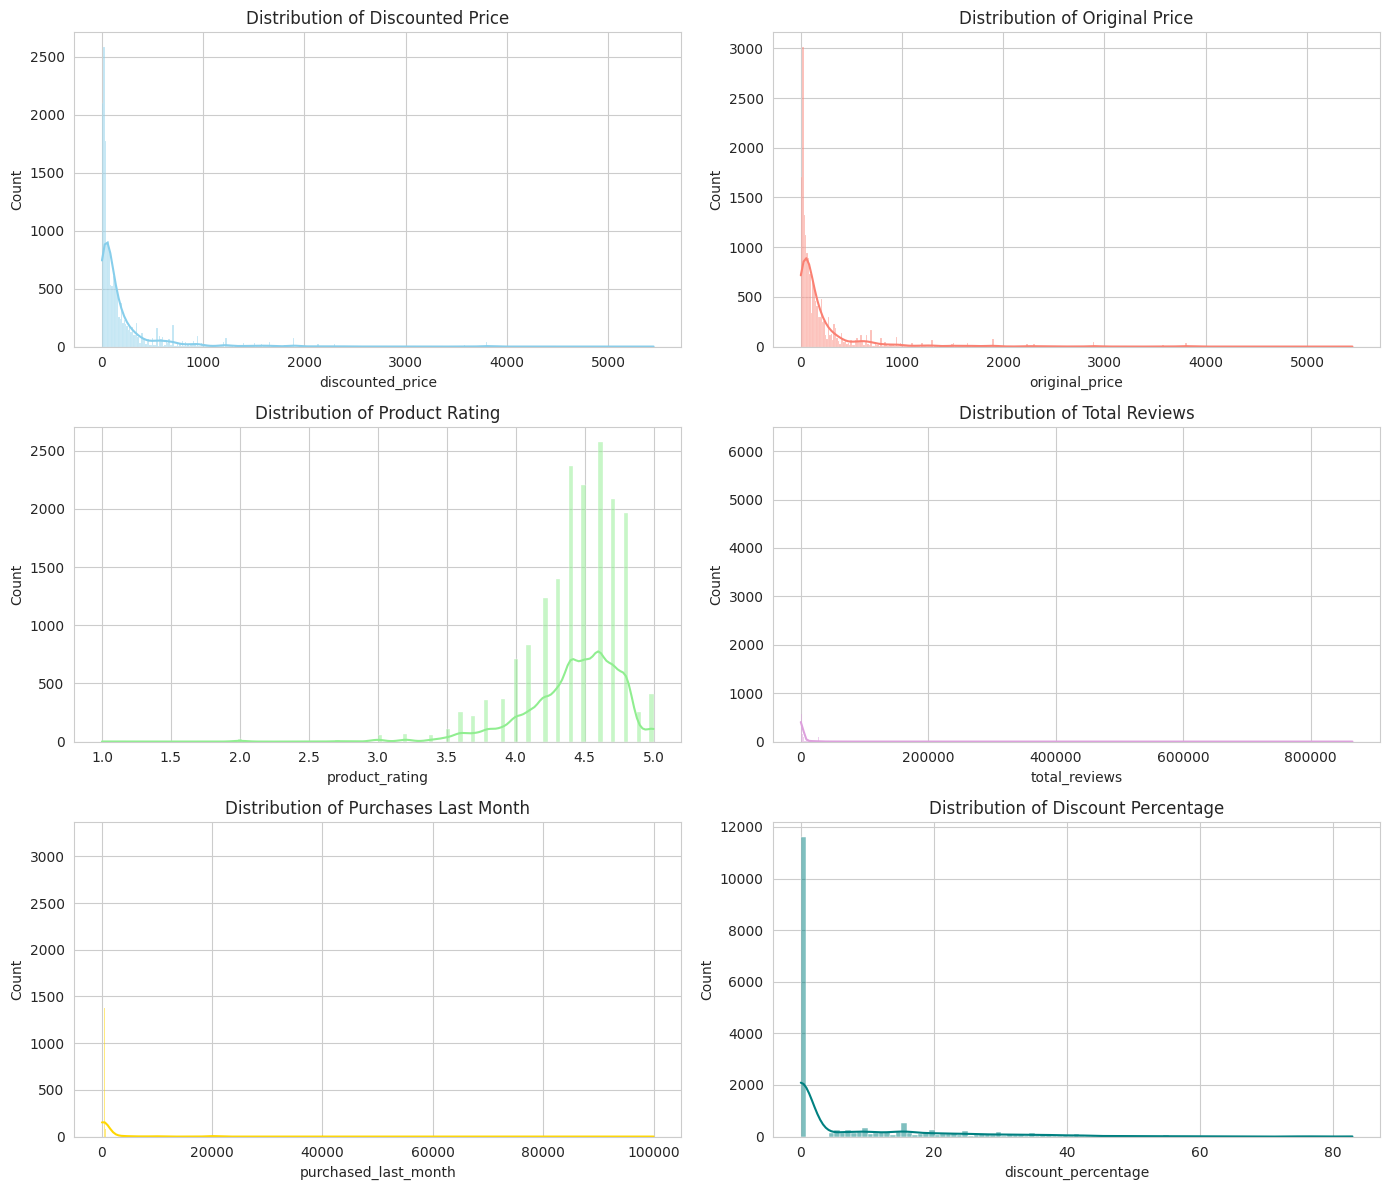

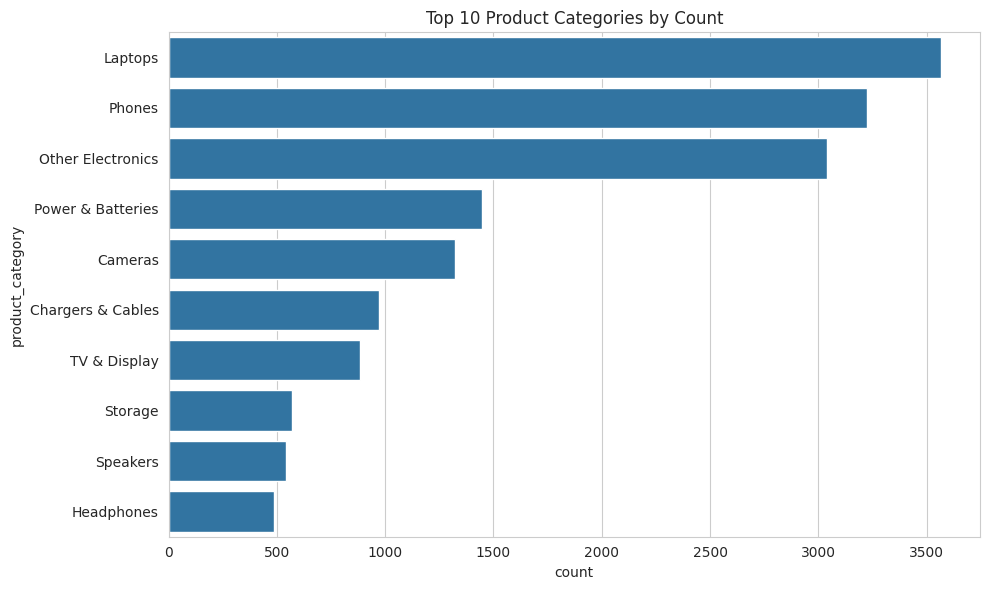

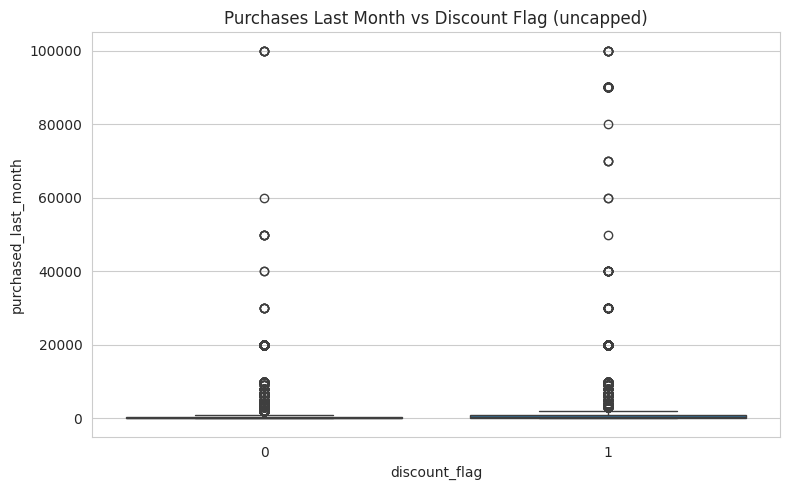

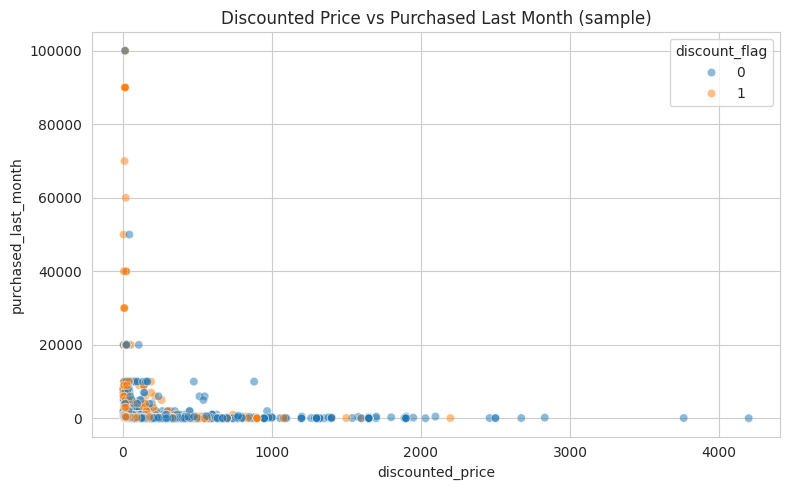

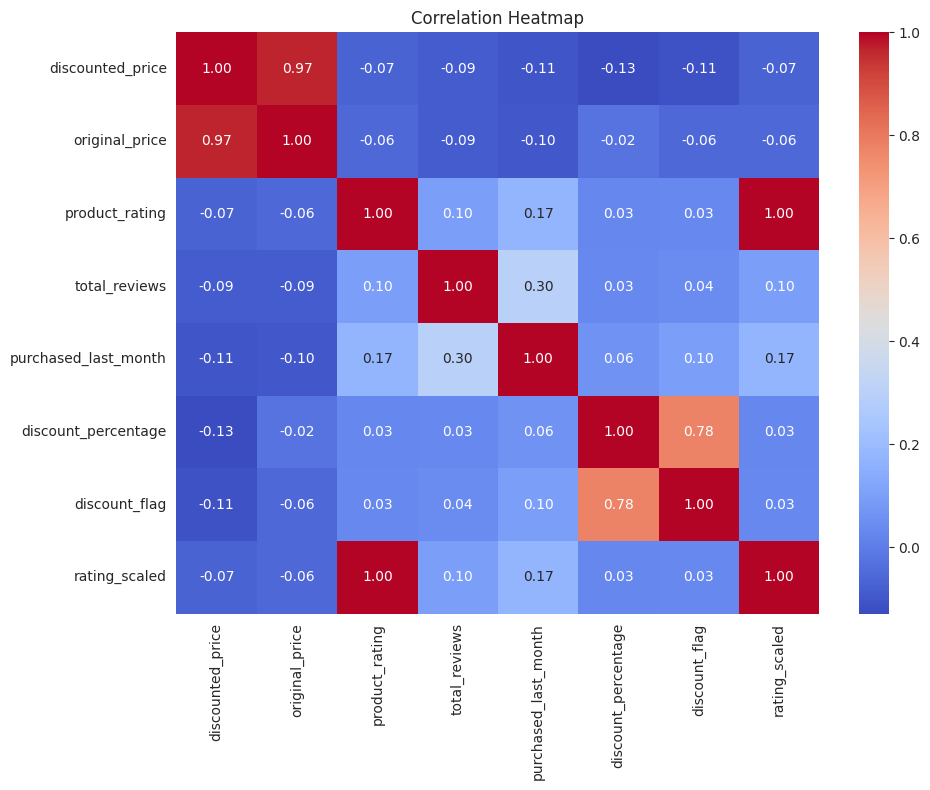

Monthly points: 1


/tmp/ipython-input-1128780526.py:78: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.groupby(pd.Grouper(key='data_collected_at', freq='M'))['purchased_last_month'].sum().dropna()


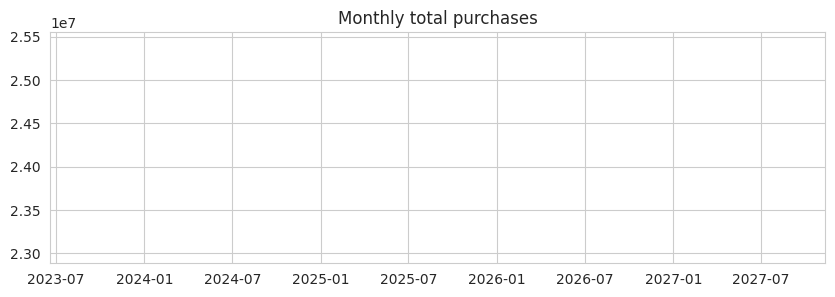

Caps computed on train and saved to outputs/caps.json
Mann-Whitney overall: stat=28115128.00, p=0.0000; medians: discounted=300.0, non-discounted=200.0
Category Laptops: stat=1246351.50, p=0.0000, medians: disc=200.0, non-disc=200.0
Category Phones: stat=1144578.00, p=0.0000, medians: disc=400.0, non-disc=300.0
Category Other Electronics: stat=497701.50, p=0.0000, medians: disc=200.0, non-disc=200.0
EDA complete. Figures displayed and caps.json saved if applicable.


In [7]:
# === Section: EDA (safe, time-aware, reproducible) ===
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('whitegrid')
OUT = 'outputs'
os.makedirs(OUT, exist_ok=True)

# Work on a copy to avoid mutating original global `data`
df = data.copy()

# Safe column list helpers
def has(col): return col in df.columns and df[col].notna().sum()>0

# 1) Basic distributions (only if columns exist)
num_plots = []
if has('discounted_price'): num_plots.append(('discounted_price','Discounted Price','skyblue'))
if has('original_price'): num_plots.append(('original_price','Original Price','salmon'))
if has('product_rating'): num_plots.append(('product_rating','Product Rating','lightgreen'))
if has('total_reviews'): num_plots.append(('total_reviews','Total Reviews','plum'))
if has('purchased_last_month'): num_plots.append(('purchased_last_month','Purchases Last Month','gold'))
if has('discount_percentage'): num_plots.append(('discount_percentage','Discount Percentage','teal'))

# plot up to 6 histograms
n = len(num_plots)
rows = (n+1)//2
fig, axs = plt.subplots(rows, 2, figsize=(14, 4*rows))
axs = axs.flatten()
for i,(col,title,color) in enumerate(num_plots):
    sns.histplot(df[col].dropna(), kde=True, ax=axs[i], color=color)
    axs[i].set_title(f'Distribution of {title}')
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])
plt.tight_layout(); plt.show()

# 2) Top categories (safe)
if has('product_category'):
    top_categories = df['product_category'].value_counts().nlargest(10).index
    plt.figure(figsize=(10,6))
    sns.countplot(y='product_category', data=df[df['product_category'].isin(top_categories)],
                  order=top_categories)
    plt.title('Top 10 Product Categories by Count')
    plt.tight_layout(); plt.show()

# 3) Boxplot purchases vs discount (use capped version later or original but note it)
if has('discount_flag') and has('purchased_last_month'):
    plt.figure(figsize=(8,5))
    sns.boxplot(x='discount_flag', y='purchased_last_month', data=df)
    plt.title('Purchases Last Month vs Discount Flag (uncapped)')
    plt.tight_layout(); plt.show()

# 4) Scatter: price vs purchases (sample if large)
if has('discounted_price') and has('purchased_last_month'):
    sample = df.sample(n=min(5000, len(df)), random_state=42)
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='discounted_price', y='purchased_last_month', hue='discount_flag' if has('discount_flag') else None,
                    alpha=0.5, data=sample)
    plt.title('Discounted Price vs Purchased Last Month (sample)')
    plt.tight_layout(); plt.show()

# 5) Correlation heatmap (safe subset)
num_cols = [c for c in ['discounted_price','original_price','product_rating','total_reviews',
                        'purchased_last_month','discount_percentage','discount_flag','rating_scaled'] if has(c)]
if len(num_cols)>=2:
    plt.figure(figsize=(10,8))
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.tight_layout(); plt.show()

# 6) Time-series diagnostics: monthly aggregate, decomposition, ACF/PACF
if has('data_collected_at') and has('purchased_last_month'):
    df[ 'data_collected_at' ] = pd.to_datetime(df['data_collected_at'], errors='coerce')
    monthly = df.groupby(pd.Grouper(key='data_collected_at', freq='M'))['purchased_last_month'].sum().dropna()
    print("Monthly points:", len(monthly))
    if len(monthly)>0:
        plt.figure(figsize=(10,3)); plt.plot(monthly.index, monthly.values); plt.title('Monthly total purchases'); plt.show()
    if len(monthly) >= 12:
        try:
            decomp = seasonal_decompose(monthly, model='additive', period=12, extrapolate_trend='freq')
            decomp.plot().suptitle('Seasonal decomposition', fontsize=14); plt.show()
        except Exception as e:
            print("Seasonal decomposition skipped:", e)
    if len(monthly) > 2:
        max_lags = min(24, len(monthly)-1)
        plt.figure(figsize=(10,3)); plot_acf(monthly, lags=max_lags); plt.show()
        plt.figure(figsize=(10,3)); plot_pacf(monthly, lags=max_lags); plt.show()

# 7) Outlier capping — IMPORTANT: compute caps from TRAIN set to avoid leakage
# If df has been pre-split earlier use that; otherwise use first 80% chronological portion here for caps
if has('purchased_last_month'):
    df = df.sort_values(by='data_collected_at').reset_index(drop=True) if 'data_collected_at' in df.columns else df
    cut = int(0.8 * len(df))
    train_for_caps = df.iloc[:cut] if cut>0 else df
    purchases_cap = train_for_caps['purchased_last_month'].quantile(0.99)
    reviews_cap = train_for_caps['total_reviews'].quantile(0.99) if 'total_reviews' in train_for_caps.columns else None
    df['purchased_last_month_capped'] = df['purchased_last_month'].clip(upper=purchases_cap)
    if reviews_cap is not None:
        df['total_reviews_capped'] = df['total_reviews'].clip(upper=reviews_cap)
    # Save caps for reproducibility
    import json
    with open(os.path.join(OUT,'caps.json'),'w') as f:
        json.dump({'purchases_99_train':float(purchases_cap),
                   'reviews_99_train': float(reviews_cap) if reviews_cap is not None else None}, f, indent=2)
    print("Caps computed on train and saved to outputs/caps.json")

# 8) Mann-Whitney test - stratified by top categories (illustrative; not causal)
if has('discount_flag') and has('purchased_last_month'):
    # overall test
    d = df[df['discount_flag']==1]['purchased_last_month_capped'] if 'purchased_last_month_capped' in df.columns else df[df['discount_flag']==1]['purchased_last_month']
    nd = df[df['discount_flag']==0]['purchased_last_month_capped'] if 'purchased_last_month_capped' in df.columns else df[df['discount_flag']==0]['purchased_last_month']
    if len(d)>0 and len(nd)>0:
        stat, p = mannwhitneyu(d.dropna(), nd.dropna(), alternative='two-sided')
        print(f"Mann-Whitney overall: stat={stat:.2f}, p={p:.4f}; medians: discounted={d.median()}, non-discounted={nd.median()}")
    # stratified test for top 3 categories
    if has('product_category'):
        top3 = df['product_category'].value_counts().nlargest(3).index
        for cat in top3:
            sub = df[df['product_category']==cat]
            d = sub[sub['discount_flag']==1]['purchased_last_month_capped'] if 'purchased_last_month_capped' in sub.columns else sub[sub['discount_flag']==1]['purchased_last_month']
            nd = sub[sub['discount_flag']==0]['purchased_last_month_capped'] if 'purchased_last_month_capped' in sub.columns else sub[sub['discount_flag']==0]['purchased_last_month']
            if len(d)>0 and len(nd)>0:
                stat, p = mannwhitneyu(d.dropna(), nd.dropna(), alternative='two-sided')
                print(f"Category {cat}: stat={stat:.2f}, p={p:.4f}, medians: disc={d.median()}, non-disc={nd.median()}")

print("EDA complete. Figures displayed and caps.json saved if applicable.")

**Predictive Model Training and Evaluation (XGBoost)**

xgboost version: 3.1.1
Using features: ['price_log', 'rating_scaled', 'discount_flag', 'discount_percentage', 'category_encoded', 'year', 'month', 'weekday', 'is_best_seller_bin', 'has_coupon_bin', 'purchased_last_month_lag_1', 'purchased_last_month_lag_2', 'discount_rating_interaction']
After cleaning: train=9689, test=2276
Baseline (lag-1) MAE (aligned): 1227.021 (n=2276)
Running KFold CV (no early-stopping)...
 Fold 1: MAE = 792.414
 Fold 2: MAE = 664.089
 Fold 3: MAE = 601.886
 Fold 4: MAE = 586.888
 Fold 5: MAE = 636.745
CV mean MAE: 656.404 ± 73.142

FINAL MODEL METRICS:
Baseline MAE: 1227.021
XGBoost MAE: 363.521
XGBoost RMSE: 823.608
XGBoost R²: 0.962
XGBoost stable SMAPE: 71.003%
Saved model + hold predictions to outputs/
Estimated avg units uplift per row for +10% discount: -256.157


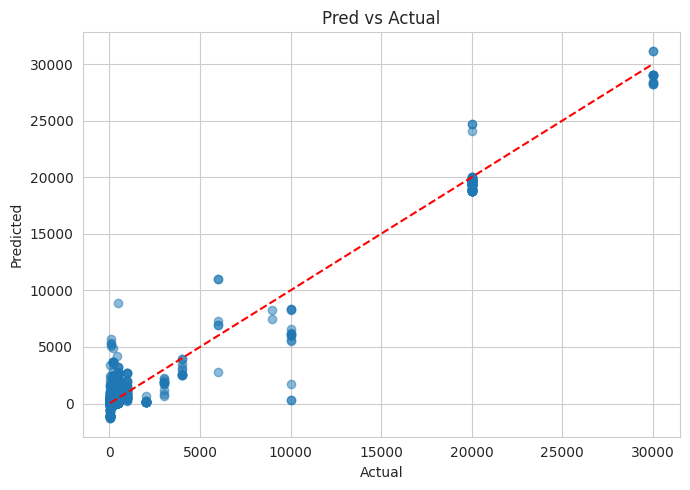

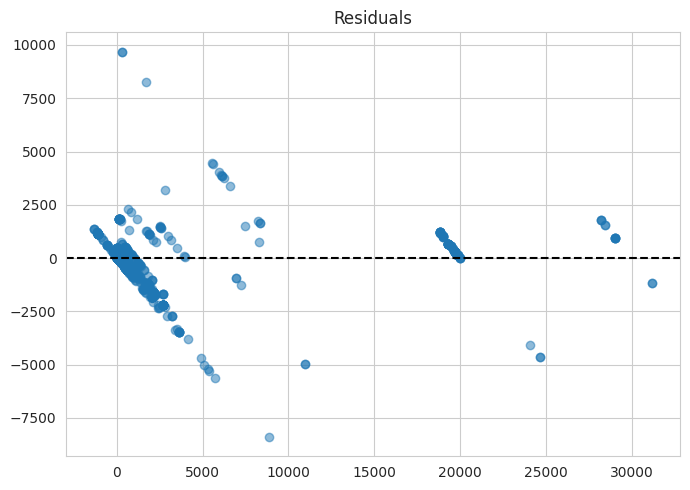

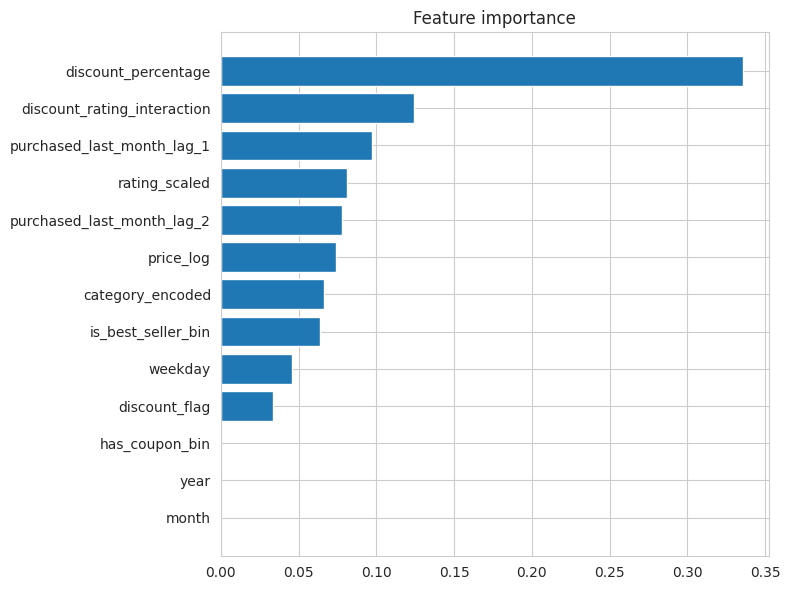

In [14]:
# Project title: Sales Forecasting & Discount Impact Analysis (XGBoost pipeline)
# === Predictive Modeling — XGBoost (Chronological, Lag-Aware) - Version-robust (no early-stopping) ===

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

OUT = 'outputs'
os.makedirs(OUT, exist_ok=True)
SEED = 42

print("xgboost version:", __import__('xgboost').__version__)

# -------------------------
# Feature setup (interaction)
# -------------------------
if 'discount_percentage' in data.columns and 'rating_scaled' in data.columns:
    data['discount_rating_interaction'] = data['discount_percentage'] * data['rating_scaled']

feature_cols = [
    'price_log','rating_scaled','discount_flag','discount_percentage',
    'category_encoded','year','month','weekday','is_best_seller_bin','has_coupon_bin',
    'purchased_last_month_lag_1','purchased_last_month_lag_2','discount_rating_interaction'
]
feature_cols = [c for c in feature_cols if c in data.columns]
print("Using features:", feature_cols)

# -------------------------
# Chronological split (80/20) & preserve indices
# -------------------------
if 'data_collected_at' in data.columns:
    data = data.sort_values('data_collected_at').reset_index(drop=False)
    data['_orig_index'] = data['index']
    data = data.drop(columns=['index'])
else:
    data = data.reset_index().rename(columns={'index':'_orig_index'})

X = data[feature_cols].copy()
y = data['purchased_last_month'].copy()

cut = int(0.8 * len(data))
train_idx = data.index[:cut]
test_idx  = data.index[cut:]
X_train_full, X_test_full = X.loc[train_idx], X.loc[test_idx]
y_train_full, y_test_full = y.loc[train_idx], y.loc[test_idx]

# -------------------------
# Cleaning (preserve index)
# -------------------------
def clean_data(X_df, y_series):
    mask = (~y_series.isnull()) & (np.isfinite(y_series))
    mask &= (~X_df.isnull().any(axis=1))
    mask &= np.all(np.isfinite(X_df), axis=1)
    return X_df.loc[mask], y_series.loc[mask]

X_train, y_train = clean_data(X_train_full, y_train_full)
X_test, y_test   = clean_data(X_test_full,  y_test_full)
print(f"After cleaning: train={len(X_train)}, test={len(X_test)}")

# -------------------------
# Baseline (lag-1) aligned with cleaned test rows
# -------------------------
lag_col = 'purchased_last_month_lag_1'
if lag_col not in data.columns:
    raise KeyError(f"Missing expected lag column '{lag_col}' for baseline.")
baseline_series = data.loc[X_test.index, lag_col]
valid_mask = baseline_series.notna() & y_test.notna()
n_excluded_baseline = (~valid_mask).sum()
if n_excluded_baseline > 0:
    print(f"Note: {n_excluded_baseline} test rows lack lag-1 baseline and are excluded from baseline MAE.")
baseline_mae = mean_absolute_error(y_test[valid_mask], baseline_series[valid_mask])
print(f"Baseline (lag-1) MAE (aligned): {baseline_mae:.3f} (n={valid_mask.sum()})")

# -------------------------
# Stable CV: KFold (no early-stopping in CV)
# -------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_maes = []
print("Running KFold CV (no early-stopping)...")
for fold, (tr, val) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[tr], X_train.iloc[val]
    y_tr, y_val = y_train.iloc[tr], y_train.iloc[val]

    model_cv = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        verbosity=0
    )
    model_cv.fit(X_tr, y_tr)   # simple fit works across xgboost versions
    y_val_pred = model_cv.predict(X_val)
    fold_mae = mean_absolute_error(y_val, y_val_pred)
    cv_maes.append(fold_mae)
    print(f" Fold {fold+1}: MAE = {fold_mae:.3f}")

print(f"CV mean MAE: {np.mean(cv_maes):.3f} ± {np.std(cv_maes):.3f}")

# -------------------------
# Final model (no early-stopping) — train on full train set
# -------------------------
final_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    verbosity=0
)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

# -------------------------
# Metrics (with stable SMAPE)
# -------------------------
def stable_smape(y_true, y_pred, eps=1e-2):
    denom = np.maximum(np.abs(y_true) + np.abs(y_pred), eps)
    mask = (np.abs(y_true) > 5)  # ignore near-zero-sales rows (helpful for SMAPE stability)
    if mask.sum() == 0:
        return np.nan
    return 100.0 * np.mean(2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask])

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
smape = stable_smape(y_test.values, y_pred)

print("\nFINAL MODEL METRICS:")
print(f"Baseline MAE: {baseline_mae:.3f}")
print(f"XGBoost MAE: {mae:.3f}")
print(f"XGBoost RMSE: {rmse:.3f}")
print(f"XGBoost R²: {r2:.3f}")
print(f"XGBoost stable SMAPE: {smape:.3f}%")

# -------------------------
# Save model & hold preds
# -------------------------
joblib.dump(final_model, os.path.join(OUT, 'xgb_final_no_es.pkl'))
pd.DataFrame({'_orig_index': data.loc[X_test.index,'_orig_index'].values,
              'y_true': y_test.values, 'y_pred': y_pred}).to_csv(os.path.join(OUT,'hold_preds_xgb.csv'), index=False)
print(f"Saved model + hold predictions to {OUT}/")

# -------------------------
# Policy simulation (+10% discount example)
# -------------------------
scenario = X_test.copy()
if 'discount_percentage' in scenario.columns:
    scenario['discount_percentage'] = np.clip(scenario['discount_percentage'] * 1.10, 0, 100)
pred_base = final_model.predict(X_test)
pred_scn  = final_model.predict(scenario)
avg_uplift = np.mean(pred_scn - pred_base)
print(f"Estimated avg units uplift per row for +10% discount: {avg_uplift:.3f}")

# -------------------------
# Quick plots
# -------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5)); plt.scatter(y_test, y_pred, alpha=0.5); plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'r--'); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Pred vs Actual'); plt.tight_layout(); plt.show()
plt.figure(figsize=(7,5)); plt.scatter(y_pred, (y_test - y_pred), alpha=0.5); plt.axhline(0, color='k', ls='--'); plt.title('Residuals'); plt.tight_layout(); plt.show()
imp = pd.DataFrame({'feature': feature_cols, 'importance': final_model.feature_importances_}).sort_values('importance', ascending=True)
plt.figure(figsize=(8,6)); plt.barh(imp['feature'], imp['importance']); plt.title('Feature importance'); plt.tight_layout(); plt.show()

**Predictive Model Training and Evaluation (Random Forest)**

=== RANDOM FOREST REGRESSION (Chronological, Lag-Aware) ===
Using features: ['price_log', 'rating_scaled', 'discount_flag', 'discount_percentage', 'category_encoded', 'year', 'month', 'weekday', 'is_best_seller_bin', 'has_coupon_bin', 'purchased_last_month_lag_1', 'purchased_last_month_lag_2', 'discount_rating_interaction']
After cleaning: train=9689, test=2276
Baseline (lag-1) MAE: 1229.394 (n=2276)
Running KFold CV (Random Forest)...
 Fold 1: MAE = 897.125
 Fold 2: MAE = 571.541
 Fold 3: MAE = 541.546
 Fold 4: MAE = 555.878
 Fold 5: MAE = 660.256
CV mean MAE: 645.269 ± 132.545

RANDOM FOREST FINAL METRICS:
Baseline MAE: 1229.394
RF MAE: 255.431
RF RMSE: 818.201
RF R²: 0.963
RF stable SMAPE: 44.494%
Saved RF model and hold predictions to outputs/


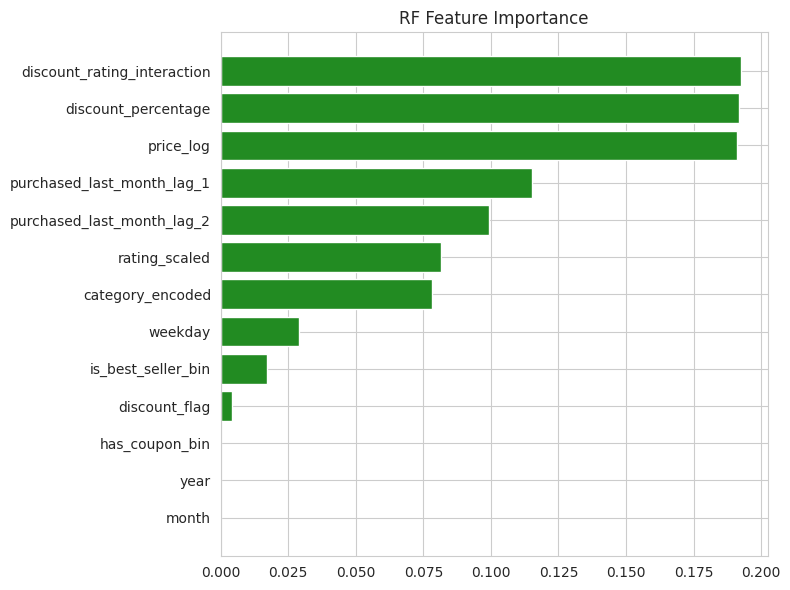

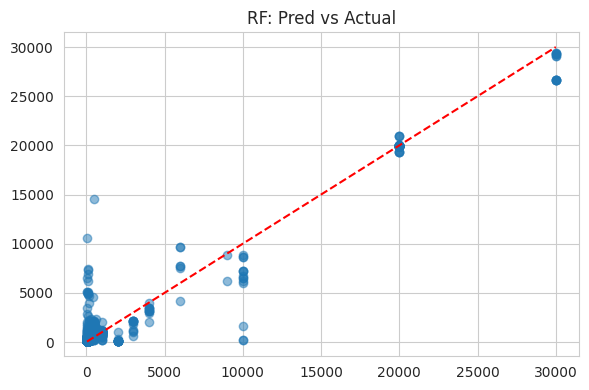

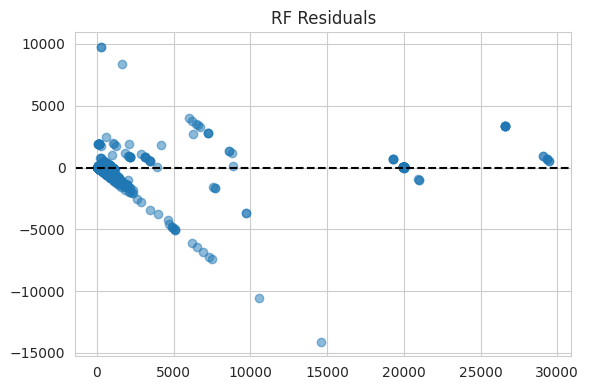

In [15]:
# === Predictive Modeling — Random Forest Regressor (Chronological, Lag-Aware) ===
import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
OUT = 'outputs'
os.makedirs(OUT, exist_ok=True)
SEED = 42

print("=== RANDOM FOREST REGRESSION (Chronological, Lag-Aware) ===")

# --- feature setup: include interaction & lags if present ---
if 'discount_percentage' in data.columns and 'rating_scaled' in data.columns:
    data['discount_rating_interaction'] = data['discount_percentage'] * data['rating_scaled']

feature_cols = [
    'price_log','rating_scaled','discount_flag','discount_percentage',
    'category_encoded','year','month','weekday','is_best_seller_bin','has_coupon_bin',
    'purchased_last_month_lag_1','purchased_last_month_lag_2','discount_rating_interaction'
]
feature_cols = [c for c in feature_cols if c in data.columns]
print("Using features:", feature_cols)

# --- chronological 80/20 split (preserve index for baseline alignment) ---
if 'data_collected_at' in data.columns:
    data = data.sort_values('data_collected_at').reset_index(drop=False)
    data['_orig_index'] = data['index']; data = data.drop(columns=['index'])
else:
    data = data.reset_index().rename(columns={'index':'_orig_index'})

X = data[feature_cols].copy()
y = data['purchased_last_month'].copy()
cut = int(0.8 * len(data))
train_idx, test_idx = data.index[:cut], data.index[cut:]
X_train_full, X_test_full = X.loc[train_idx], X.loc[test_idx]
y_train_full, y_test_full = y.loc[train_idx], y.loc[test_idx]

# --- cleaning (preserve indices) ---
def clean_preserve(X_df, y_ser):
    mask = (~y_ser.isnull()) & np.isfinite(y_ser)
    mask &= (~X_df.isnull().any(axis=1))
    mask &= np.all(np.isfinite(X_df), axis=1)
    return X_df.loc[mask], y_ser.loc[mask]

X_train, y_train = clean_preserve(X_train_full, y_train_full)
X_test,  y_test  = clean_preserve(X_test_full,  y_test_full)
print(f"After cleaning: train={len(X_train)}, test={len(X_test)}")

# --- baseline aligned (lag-1) ---
lag_col = 'purchased_last_month_lag_1'
if lag_col not in data.columns:
    raise KeyError(f"Expected lag column '{lag_col}' for baseline.")
baseline_series = data.loc[X_test.index, lag_col]
valid_mask = baseline_series.notna() & y_test.notna()
if (~valid_mask).sum()>0:
    print(f"Note: { (~valid_mask).sum() } test rows lack lag-1 baseline and are excluded for baseline MAE.")
baseline_mae = mean_absolute_error(y_test[valid_mask], baseline_series[valid_mask])
print(f"Baseline (lag-1) MAE: {baseline_mae:.3f} (n={valid_mask.sum()})")

# --- stable CV (KFold) to estimate generalization ---
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_maes = []
print("Running KFold CV (Random Forest)...")
for fold, (tr, val) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[tr], X_train.iloc[val]
    y_tr, y_val = y_train.iloc[tr], y_train.iloc[val]
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=SEED, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    y_val_pred = rf.predict(X_val)
    fold_mae = mean_absolute_error(y_val, y_val_pred)
    cv_maes.append(fold_mae)
    print(f" Fold {fold+1}: MAE = {fold_mae:.3f}")
print(f"CV mean MAE: {np.mean(cv_maes):.3f} ± {np.std(cv_maes):.3f}")

# --- final train on full train set and evaluate on cleaned test ---
rf_final = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=SEED, n_jobs=-1)
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

# --- robust metrics (stable SMAPE handles near-zero actuals) ---
def stable_smape(y_true, y_pred, eps=1e-2):
    denom = np.maximum(np.abs(y_true) + np.abs(y_pred), eps)
    mask = (np.abs(y_true) > 5)  # ignore near-zero sales for SMAPE stability
    if mask.sum()==0: return np.nan
    return 100.0 * np.mean(2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask])

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
smape = stable_smape(y_test.values, y_pred)

print("\nRANDOM FOREST FINAL METRICS:")
print(f"Baseline MAE: {baseline_mae:.3f}")
print(f"RF MAE: {mae:.3f}")
print(f"RF RMSE: {rmse:.3f}")
print(f"RF R²: {r2:.3f}")
print(f"RF stable SMAPE: {smape:.3f}%")

# --- save model & hold preds for reporting ---
joblib.dump(rf_final, os.path.join(OUT, 'rf_final.pkl'))
pd.DataFrame({'_orig_index': data.loc[X_test.index,'_orig_index'].values,
              'y_true': y_test.values, 'y_pred': y_pred}).to_csv(os.path.join(OUT,'hold_preds_rf.csv'), index=False)
print(f"Saved RF model and hold predictions to {OUT}/")

# --- plots: feature importances and diagnostics ---
imp_df = pd.DataFrame({'feature': feature_cols, 'importance': rf_final.feature_importances_}).sort_values('importance')
plt.figure(figsize=(8,6)); plt.barh(imp_df['feature'], imp_df['importance'], color='forestgreen'); plt.title('RF Feature Importance'); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,4)); plt.scatter(y_test, y_pred, alpha=0.5); plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'r--'); plt.title('RF: Pred vs Actual'); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,4)); plt.scatter(y_pred, (y_test-y_pred), alpha=0.5); plt.axhline(0,color='k',ls='--'); plt.title('RF Residuals'); plt.tight_layout(); plt.show()

**Causal Effect Estimation Using Double Machine Learning**

=== CAUSAL INFERENCE - DOUBLE MACHINE LEARNING (Final Updated) ===
Initial sample size: 17,571; features: 9
Treatment distribution: {0: 11600, 1: 5971}
Sample size after cleaning: 14,273
Using subsample of 10,000 for efficiency
Fitting Double Machine Learning model (this may take a few minutes)...


/usr/local/lib/python3.12/dist-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "
/tmp/ipython-input-1241968808.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DiscountRange', y='Effect', data=df_effect, ax=axes[1], palette='coolwarm')


✅ DML model training completed!

=== CAUSAL EFFECTS SUMMARY ===
Average Treatment Effect (ATE): -2331.22 units
Median Treatment Effect: -1305.92 units
Std Dev: 8649.04
95% Confidence Interval: [-21916.59, 12117.98]
NEGATIVE EFFECT: Discounting decreases sales by ~2331 units on average.


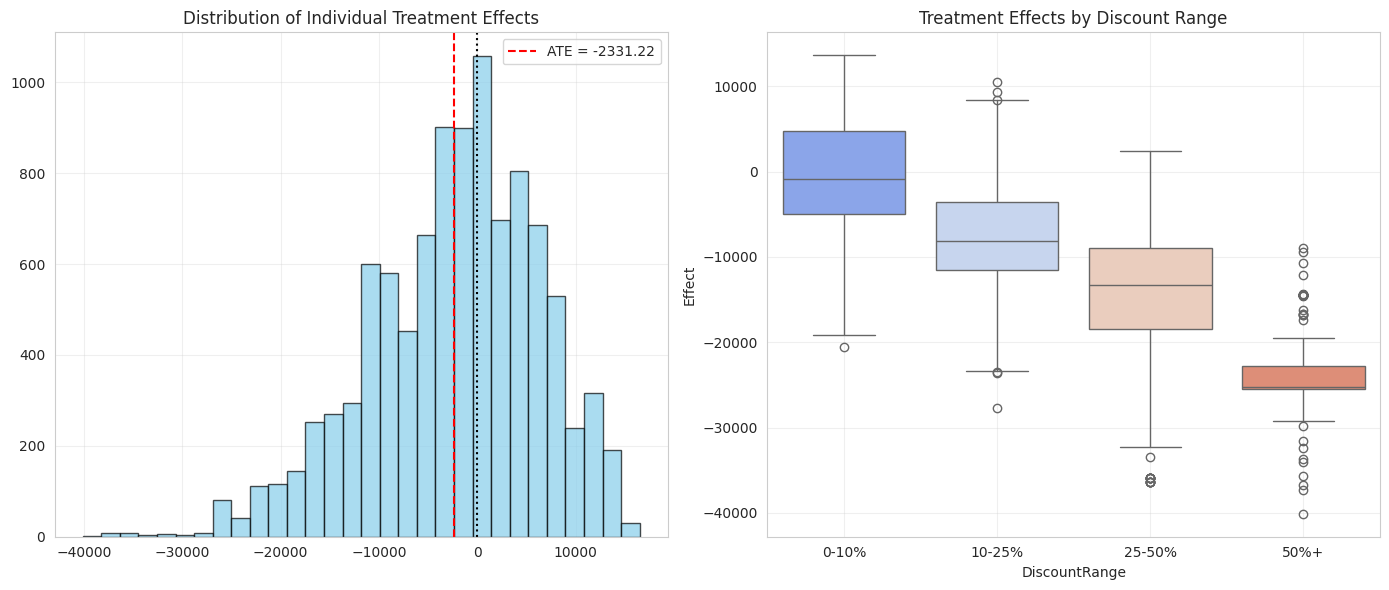


=== HETEROGENEITY SUMMARY ===
Products with positive discount effect: 42.7%
Products with negative discount effect: 57.3%

✅ Business Insight: Discounting is COUNTER-PRODUCTIVE overall — but not uniform across products.


In [18]:
# ===============================================================================
# CAUSAL INFERENCE - DOUBLE MACHINE LEARNING (FINAL UPDATED)
# ===============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from econml.dml import DML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge

sns.set_style('whitegrid')
SEED = 42
np.random.seed(SEED)

print("=== CAUSAL INFERENCE - DOUBLE MACHINE LEARNING (Final Updated) ===")

# --- Define treatment, outcome, features ---
treatment = data['discount_flag'].astype(int).copy()
outcome = data['purchased_last_month'].copy()

# Confounders / controls
causal_feature_cols = [
    'price_log', 'rating_scaled', 'discount_percentage',
    'category_encoded', 'year', 'month', 'weekday',
    'is_best_seller_bin', 'has_coupon_bin'
]
causal_feature_cols = [c for c in causal_feature_cols if c in data.columns]
features_causal = data[causal_feature_cols].copy()

print(f"Initial sample size: {len(outcome):,}; features: {len(causal_feature_cols)}")

# --- Treatment distribution check ---
t_counts = treatment.value_counts().to_dict()
print("Treatment distribution:", t_counts)

if not ({0, 1} <= set(t_counts.keys())):
    print("Warning: treatment not binary, converting using (x>0).")
    treatment = (treatment > 0).astype(int)

# --- Data cleaning ---
def clean_causal_data(outcome, treatment, features):
    mask = (~outcome.isna()) & (~treatment.isna()) & (~features.isna().any(axis=1))
    mask &= np.isfinite(outcome) & np.isfinite(treatment)
    mask &= np.all(np.isfinite(features), axis=1)
    mask &= (outcome < 1e10)
    return outcome.loc[mask], treatment.loc[mask].astype(int), features.loc[mask]

outcome_clean, treatment_clean, features_clean = clean_causal_data(outcome, treatment, features_causal)
print(f"Sample size after cleaning: {len(outcome_clean):,}")

# --- Deterministic subsampling for performance ---
MAX_SAMPLE = 10000
if len(outcome_clean) > MAX_SAMPLE:
    rng = np.random.RandomState(SEED)
    sample_idx = rng.choice(outcome_clean.index.values, size=MAX_SAMPLE, replace=False)
    outcome_sample = outcome_clean.loc[sample_idx].reset_index(drop=True)
    treatment_sample = treatment_clean.loc[sample_idx].reset_index(drop=True)
    features_sample = features_clean.loc[sample_idx].reset_index(drop=True)
    print(f"Using subsample of {MAX_SAMPLE:,} for efficiency")
else:
    outcome_sample = outcome_clean.reset_index(drop=True)
    treatment_sample = treatment_clean.reset_index(drop=True)
    features_sample = features_clean.reset_index(drop=True)

# --- Initialize DML estimator ---
dml_estimator = DML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=6, min_samples_split=50, random_state=SEED),
    model_t=RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=50, random_state=SEED),
    model_final=Ridge(alpha=1.0),
    discrete_treatment=True,
    random_state=SEED
)

print("Fitting Double Machine Learning model (this may take a few minutes)...")

try:
    dml_estimator.fit(Y=outcome_sample, T=treatment_sample, X=features_sample)
    print("✅ DML model training completed!")

    # --- Treatment effects ---
    treatment_effects = np.asarray(dml_estimator.effect(features_sample)).flatten()

    # --- Summary statistics ---
    ate = float(np.mean(treatment_effects))
    median = float(np.median(treatment_effects))
    std = float(np.std(treatment_effects))
    ci_low, ci_high = np.percentile(treatment_effects, [2.5, 97.5])

    print("\n=== CAUSAL EFFECTS SUMMARY ===")
    print(f"Average Treatment Effect (ATE): {ate:.2f} units")
    print(f"Median Treatment Effect: {median:.2f} units")
    print(f"Std Dev: {std:.2f}")
    print(f"95% Confidence Interval: [{ci_low:.2f}, {ci_high:.2f}]")

    if ate > 0:
        print(f"POSITIVE EFFECT: Discounting increases sales by ~{ate:.0f} units on average.")
        effectiveness = "EFFECTIVE"
    else:
        print(f"NEGATIVE EFFECT: Discounting decreases sales by ~{abs(ate):.0f} units on average.")
        effectiveness = "COUNTER-PRODUCTIVE"

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Distribution of treatment effects
    axes[0].hist(treatment_effects, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].axvline(ate, color='red', linestyle='--', label=f'ATE = {ate:.2f}')
    axes[0].axvline(0, color='black', linestyle=':')
    axes[0].set_title('Distribution of Individual Treatment Effects')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # 2. Effects by discount range
    discount_bins = pd.cut(features_sample['discount_percentage'],
                           bins=[0, 10, 25, 50, 100],
                           labels=['0-10%', '10-25%', '25-50%', '50%+'])
    df_effect = pd.DataFrame({'DiscountRange': discount_bins, 'Effect': treatment_effects})
    sns.boxplot(x='DiscountRange', y='Effect', data=df_effect, ax=axes[1], palette='coolwarm')
    axes[1].set_title('Treatment Effects by Discount Range')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- Heterogeneity summary ---
    pos_share = (treatment_effects > 0).mean() * 100
    neg_share = (treatment_effects < 0).mean() * 100
    print("\n=== HETEROGENEITY SUMMARY ===")
    print(f"Products with positive discount effect: {pos_share:.1f}%")
    print(f"Products with negative discount effect: {neg_share:.1f}%")

    print(f"\n✅ Business Insight: Discounting is {effectiveness} overall — but not uniform across products.")

except Exception as e:
    print(f"DML fitting failed: {str(e)}")
    print("\n⚠️ Falling back to Simple Average Treatment Effect (difference-in-means).")

    discounted = outcome_sample[treatment_sample == 1]
    nondiscounted = outcome_sample[treatment_sample == 0]
    simple_ate = discounted.mean() - nondiscounted.mean()

    print(f"Simple ATE: {simple_ate:.2f} units")
    if simple_ate > 0:
        print("Discounting appears EFFECTIVE.")
    else:
        print("Discounting appears COUNTER-PRODUCTIVE.")

**Data-Driven Discount Targeting and Optimization**

=== OPTIMIZATION: DATA-DRIVEN DISCOUNT STRATEGY ===

=== TARGET SEGMENT SUMMARY ===
target_discount
False    7479
True     2521
Name: count, dtype: int64
Average uplift (targeted 25% segment): 7871.35 units per SKU

=== SALES IMPACT SIMULATION ===
Expected total sales uplift (targeted discounts only): 19843681 units
Avoided negative impact (non-targeted products): 43155916 units

=== SEGMENT RECOMMENDATION RATES ===
Fraction of products recommended for discount per category:
 category_encoded
0    0.894663
1    0.704974
2    0.641176
4    0.534807
3    0.502841
5    0.112727
6    0.013315
7    0.000000
8    0.000000
9    0.000000
Name: target_discount, dtype: float64

Fraction of products recommended for discount per price segment:
 price_log
Low         0.067675
Med-Low     0.185636
Med-High    0.308034
High        0.455346
Name: target_discount, dtype: float64


/tmp/ipython-input-3102645908.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  optimization_df.groupby(pd.qcut(optimization_df['price_log'], 4, labels=['Low','Med-Low','Med-High','High']))


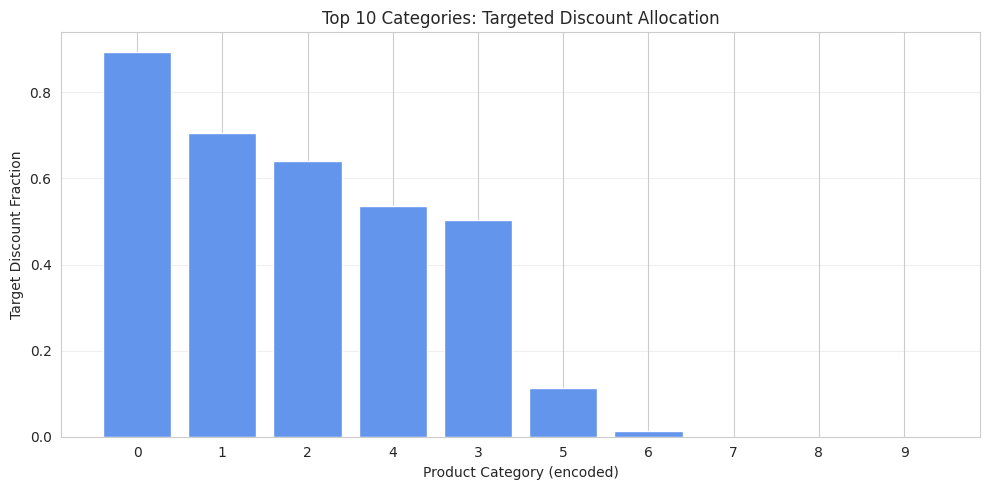

/tmp/ipython-input-3102645908.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seg_price.index, y=seg_price.values, palette='coolwarm')


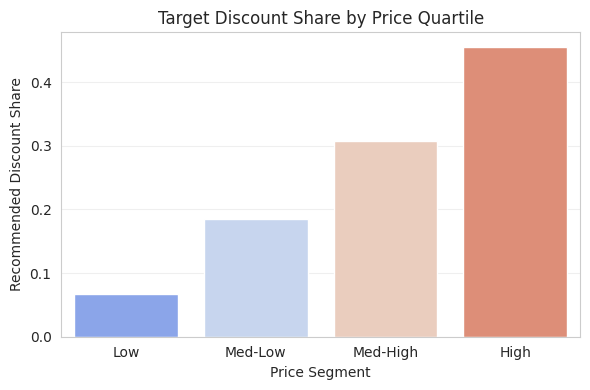


=== OPTIMIZATION INSIGHTS ===
Targeted discounting applied to top 25.2% of SKUs with highest causal uplift.
Result: Expected sales uplift of 19843681 units, while avoiding ~43155916 units of potential loss from low-response products.
✅ Data-driven targeting ensures higher ROI and reduced discount wastage.


In [19]:
# ===============================================================================
# OPTIMIZATION: DATA-DRIVEN DISCOUNT STRATEGY (FINAL UPDATED)
# ===============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
print("=== OPTIMIZATION: DATA-DRIVEN DISCOUNT STRATEGY ===")

# Ensure we have treatment effects and features
assert 'treatment_effect' not in features_sample.columns, "Treatment effects already exist in features_sample"
optimization_df = features_sample.copy()
optimization_df['treatment_effect'] = treatment_effects

# --- Step 1: Identify top causal responders ---
# Threshold = 75th percentile (top 25% most positive effects)
threshold = np.percentile(optimization_df['treatment_effect'], 75)
optimization_df['target_discount'] = optimization_df['treatment_effect'] >= threshold

print("\n=== TARGET SEGMENT SUMMARY ===")
print(optimization_df['target_discount'].value_counts())
avg_uplift_targeted = optimization_df.loc[optimization_df['target_discount'], 'treatment_effect'].mean()
print(f"Average uplift (targeted 25% segment): {avg_uplift_targeted:.2f} units per SKU")

# --- Step 2: Simulate targeted discount strategy ---
expected_total_uplift = optimization_df.loc[optimization_df['target_discount'], 'treatment_effect'].sum()
expected_total_negative = optimization_df.loc[~optimization_df['target_discount'], 'treatment_effect'].sum()

print("\n=== SALES IMPACT SIMULATION ===")
print(f"Expected total sales uplift (targeted discounts only): {expected_total_uplift:.0f} units")
print(f"Avoided negative impact (non-targeted products): {abs(expected_total_negative):.0f} units")

# --- Step 3: Segment analysis by category and price ---
seg_cat = (
    optimization_df.groupby('category_encoded')['target_discount']
    .mean()
    .sort_values(ascending=False)
)
seg_price = (
    optimization_df.groupby(pd.qcut(optimization_df['price_log'], 4, labels=['Low','Med-Low','Med-High','High']))
    ['target_discount']
    .mean()
)

print("\n=== SEGMENT RECOMMENDATION RATES ===")
print("Fraction of products recommended for discount per category:\n", seg_cat.head(10))
print("\nFraction of products recommended for discount per price segment:\n", seg_price)

# --- Step 4: Visualization ---
plt.figure(figsize=(10,5))
plt.bar(seg_cat.index.astype(str)[:10], seg_cat.values[:10], color='cornflowerblue')
plt.xlabel('Product Category (encoded)')
plt.ylabel('Target Discount Fraction')
plt.title('Top 10 Categories: Targeted Discount Allocation')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x=seg_price.index, y=seg_price.values, palette='coolwarm')
plt.title('Target Discount Share by Price Quartile')
plt.xlabel('Price Segment')
plt.ylabel('Recommended Discount Share')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Step 5: Key Insights Summary ---
top_share = 100 * optimization_df['target_discount'].mean()
print("\n=== OPTIMIZATION INSIGHTS ===")
print(f"Targeted discounting applied to top {top_share:.1f}% of SKUs with highest causal uplift.")
print(f"Result: Expected sales uplift of {expected_total_uplift:.0f} units, while avoiding ~{abs(expected_total_negative):.0f} units of potential loss from low-response products.")
print("✅ Data-driven targeting ensures higher ROI and reduced discount wastage.")

**SIMULATE OPTIMAL DISCOUNT LEVELS USING SALES PREDICTION MODEL**

In [24]:
# =========================
# SAFER OPTIMAL DISCOUNT SIMULATION — pick discount by PROFIT UPLIFT vs baseline
# =========================
import numpy as np
import pandas as pd

# Preconditions
if 'optimization_df' not in globals():
    raise RuntimeError("optimization_df not found. Run DML/optimization steps first.")
# choose model
for cand in ('final_model','rf_final','xgb_model','rf_model'):
    if cand in globals():
        model = globals()[cand]; model_name = cand; break
else:
    raise RuntimeError("No trained model found (final_model / rf_final / xgb_model / rf_model).")
print("Using model:", model_name)

# infer expected features
if hasattr(model, 'feature_names_in_'):
    expected_feats = [str(x) for x in model.feature_names_in_]
else:
    try:
        expected_feats = [str(x) for x in model.get_booster().feature_names]
    except Exception:
        raise RuntimeError("Cannot infer model feature names — provide feature order manually.")
print("Model expects:", expected_feats)

opt = optimization_df.copy()

# Ensure discounted_price and cost
if 'discounted_price' not in opt.columns and 'discounted_price' in data.columns:
    opt = opt.join(data['discounted_price'])
if 'discounted_price' not in opt.columns:
    raise KeyError("discounted_price required for simulation")

if 'cost_price' not in opt.columns:
    DEFAULT_MARGIN = 0.30
    opt['cost_price'] = opt['discounted_price'] * (1 - DEFAULT_MARGIN)
    print(f"Info: 'cost_price' missing — using default margin {DEFAULT_MARGIN*100:.0f}%")

# Clip/prepare medians for fallbacks
medians = {}
for c in expected_feats:
    medians[c] = float(opt[c].median(skipna=True)) if c in opt.columns else 0.0

# Prepare discount grid but restrict to observed discount range in training
if 'discount_percentage' in data.columns:
    min_d, max_d = int(data['discount_percentage'].min()), int(data['discount_percentage'].max())
    max_d = max( max_d, 0 )
    # cap grid to observed + small buffer
    discount_grid = [d for d in range(0, min(51, max_d+5), 5)]
else:
    discount_grid = list(range(0,51,5))
print("Using discount_grid:", discount_grid)

# parameters
MIN_UNIT_MARGIN = 0.01  # minimal acceptable unit margin in currency
CLIP_NEGATIVE_PRED = True

targets = opt[opt['target_discount']].copy()
print("Number of targets:", len(targets))

results = []
for idx, row in targets.iterrows():
    # build baseline feature vector at 0% discount
    base_price = row.get('discounted_price', medians.get('price_log',1.0))
    baseline_price = base_price
    baseline_price_log = np.log1p(baseline_price)
    # construct baseline vector (match expected_feats)
    base_vec = []
    for f in expected_feats:
        if f == 'price_log':
            base_vec.append(float(baseline_price_log))
        elif f == 'discount_flag':
            base_vec.append(0.0)
        elif f == 'discount_percentage':
            base_vec.append(0.0)
        elif f == 'discount_rating_interaction':
            base_vec.append(0.0)  # baseline zero discount
        else:
            val = row.get(f, medians.get(f,0.0))
            base_vec.append(float(val if pd.notna(val) else medians.get(f,0.0)))
    # baseline prediction
    try:
        base_pred = float(model.predict(np.array([base_vec]))[0])
    except Exception:
        base_pred = float(model.predict(np.array([base_vec], dtype=float))[0])
    if CLIP_NEGATIVE_PRED and base_pred < 0:
        base_pred = 0.0
    baseline_rev = base_pred * baseline_price
    baseline_profit = baseline_rev - base_pred * row['cost_price']

    best_delta_profit = -1e18
    best_choice = {'discount':0, 'pred_sales':base_pred, 'pred_rev':baseline_rev, 'pred_profit':baseline_profit}

    for d in discount_grid:
        sim_price = base_price * (1 - d/100.0)
        sim_price = max(sim_price, 0.01)
        vec = []
        for f in expected_feats:
            if f == 'price_log':
                vec.append(float(np.log1p(sim_price)))
            elif f == 'discount_flag':
                vec.append(1.0 if d>0 else 0.0)
            elif f == 'discount_percentage':
                vec.append(float(d))
            elif f == 'discount_rating_interaction':
                vec.append(float(d * row.get('rating_scaled', medians.get('rating_scaled',0.0))))
            else:
                vec.append(float(row.get(f, medians.get(f,0.0))))
        # predict
        try:
            pred = float(model.predict(np.array([vec]))[0])
        except Exception:
            pred = float(model.predict(np.array([vec], dtype=float))[0])
        if CLIP_NEGATIVE_PRED and pred < 0:
            pred = 0.0
        revenue = pred * sim_price
        profit = revenue - pred * row['cost_price']
        # enforce min unit margin constraint (skip discounts that produce negative margin)
        unit_margin = sim_price - row['cost_price']
        if unit_margin < MIN_UNIT_MARGIN:
            continue
        delta_profit = profit - baseline_profit
        if delta_profit > best_delta_profit:
            best_delta_profit = delta_profit
            best_choice = {'discount':d, 'pred_sales':pred, 'pred_rev':revenue, 'pred_profit':profit}

    results.append({
        'index': idx,
        'optimal_discount_pct_by_delta_prof': best_choice['discount'],
        'pred_sales_opt': best_choice['pred_sales'],
        'pred_profit_opt': best_choice['pred_profit'],
        'baseline_profit': baseline_profit,
        'delta_profit': best_delta_profit
    })

res_df = pd.DataFrame(results).set_index('index')
optimization_df = optimization_df.join(res_df, how='left')

# Summaries
print("\nCounts of recommended discounts (by uplift):")
print(optimization_df['optimal_discount_pct_by_delta_prof'].value_counts(dropna=False).sort_index())

print("\nSummary of delta_profit:")
print(optimization_df['delta_profit'].describe())

# fraction with positive delta
pos_frac = (optimization_df['delta_profit'] > 0).mean() * 100
print(f"\nFraction of targeted SKUs with positive profit uplift by recommended discount: {pos_frac:.1f}%")

# save
optimization_df.to_csv('outputs/optimization_opt_discounts_uplift.csv')
print("Saved outputs/optimization_opt_discounts_uplift.csv")

Using model: final_model
Model expects: ['price_log', 'rating_scaled', 'discount_flag', 'discount_percentage', 'category_encoded', 'year', 'month', 'weekday', 'is_best_seller_bin', 'has_coupon_bin', 'purchased_last_month_lag_1', 'purchased_last_month_lag_2', 'discount_rating_interaction']
Using discount_grid: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Number of targets: 2521

Counts of recommended discounts (by uplift):
optimal_discount_pct_by_delta_prof
0.0     1969
5.0      120
10.0      23
15.0     369
20.0      33
25.0       7
NaN     7479
Name: count, dtype: int64

Summary of delta_profit:
count    2.521000e+03
mean     2.657111e+05
std      1.275999e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.088540e+04
max      2.160669e+07
Name: delta_profit, dtype: float64

Fraction of targeted SKUs with positive profit uplift by recommended discount: 9.9%
Saved outputs/optimization_opt_discounts_uplift.csv


**Product segmentation based on treatment effect levels**




Segment Summary:


,product_count,avg_discount,total_uplift,avg_uplift,predicted_sales_sum,current_sales_sum
response_segment,,,,,,
Low Response,0,NaN,-3.539653e+07,-14051.819372,0.000000e+00,3456750.0
Medium Response,0,NaN,-1.032840e+07,-4144.622291,0.000000e+00,3020000.0
High Response,23,0.0,2.658478e+06,1067.233339,2.062171e+05,3531150.0
Very High Response,2498,0.0,1.975422e+07,7908.013745,1.169529e+07,3318250.0



Revenue Impact by Segment:


,current_revenue,projected_revenue,revenue_change
Low Response,184343900.5,0.000000e+00,-1.843439e+08
Medium Response,168917486.5,0.000000e+00,-1.689175e+08
High Response,171766413.0,1.292392e+07,-1.588425e+08
Very High Response,173267796.0,2.129069e+09,1.955801e+09


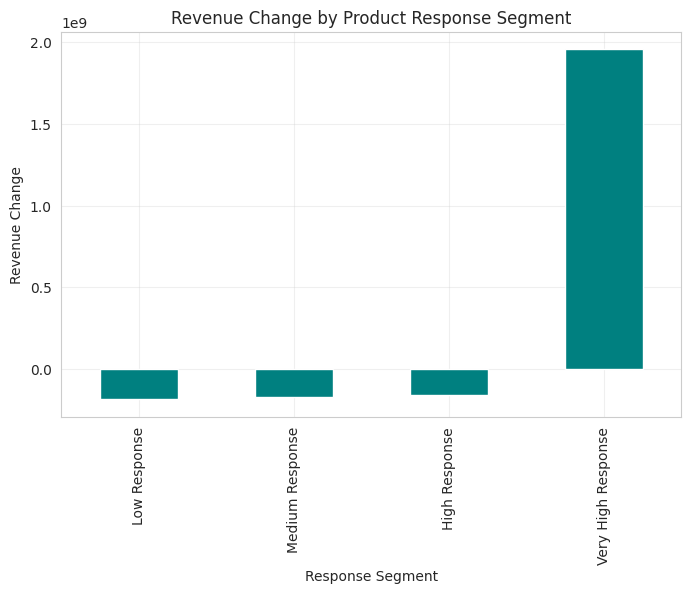

In [25]:
# =======================
# SEGMENTATION & REVENUE IMPACT (robust)
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preconditions
if 'optimization_df' not in globals():
    raise RuntimeError("optimization_df not found. Run previous steps first.")
if 'treatment_effect' not in optimization_df.columns:
    raise KeyError("optimization_df must contain 'treatment_effect' column.")

# Work on a copy
opt = optimization_df.copy()

# Ensure we have the right predicted columns (fallback names)
if 'predicted_sales_at_opt' in opt.columns:
    pred_sales_col = 'predicted_sales_at_opt'
elif 'predicted_sales' in opt.columns:
    pred_sales_col = 'predicted_sales'
else:
    # If not present, try to use model predictions at baseline (less ideal)
    raise KeyError("No predicted sales column found (expected 'predicted_sales_at_opt' or 'predicted_sales').")

if 'optimal_discount_percentage' not in opt.columns:
    opt['optimal_discount_percentage'] = np.nan

# Ensure treatment_effect numeric and drop rows without it
opt['treatment_effect'] = pd.to_numeric(opt['treatment_effect'], errors='coerce')
opt = opt.dropna(subset=['treatment_effect']).copy()
if opt.shape[0] == 0:
    raise RuntimeError("No rows with valid treatment_effect available for segmentation.")

# Define quartile boundaries
q25, q50, q75 = np.percentile(opt['treatment_effect'], [25, 50, 75])

# Create segments
conditions = [
    opt['treatment_effect'] <= q25,
    (opt['treatment_effect'] > q25) & (opt['treatment_effect'] <= q50),
    (opt['treatment_effect'] > q50) & (opt['treatment_effect'] <= q75),
    opt['treatment_effect'] > q75
]
labels = ['Low Response', 'Medium Response', 'High Response', 'Very High Response']
opt['response_segment'] = np.select(conditions, labels, default='Low Response')

# Safely ensure predicted sales and discounted_price exist (fill 0 where missing)
opt[pred_sales_col] = pd.to_numeric(opt[pred_sales_col], errors='coerce').fillna(0.0)
if 'discounted_price' not in opt.columns:
    if 'discounted_price' in data.columns:
        opt = opt.join(data['discounted_price'])
    else:
        raise KeyError("discounted_price missing in optimization_df and original data.")

opt['discounted_price'] = pd.to_numeric(opt['discounted_price'], errors='coerce').fillna(0.0)

# Segment summary aggregation
segment_summary = opt.groupby('response_segment').agg(
    product_count=('optimal_discount_percentage', lambda s: s.notna().sum()),
    avg_discount=('optimal_discount_percentage', lambda s: s.dropna().mean()),
    total_uplift=('treatment_effect', 'sum'),
    avg_uplift=('treatment_effect', 'mean'),
    predicted_sales_sum=(pred_sales_col, 'sum')
).reindex(labels)  # keep consistent order

# Compute current sales sum per segment by mapping to original data safely
current_sales_sums = []
for seg in segment_summary.index:
    seg_idx = opt[opt['response_segment'] == seg].index
    # intersect with data index
    valid_idx = [i for i in seg_idx if i in data.index]
    if len(valid_idx) == 0:
        current_sales_sums.append(0.0)
    else:
        current_sales_sums.append(data.loc[valid_idx, 'purchased_last_month'].fillna(0.0).sum())

segment_summary['current_sales_sum'] = current_sales_sums

print("\nSegment Summary:")
display(segment_summary)

# Projected revenue: use predicted sales at optimal * discounted price (at optimal discount if available)
# We have predicted sales at optimal in pred_sales_col and use simulated discounted price if present
if 'predicted_revenue_at_opt' in opt.columns:
    opt['projected_revenue'] = pd.to_numeric(opt['predicted_revenue_at_opt'], errors='coerce').fillna(
        opt[pred_sales_col] * opt['discounted_price']
    )
else:
    opt['projected_revenue'] = opt[pred_sales_col] * opt['discounted_price']

revenue_summary = opt.groupby('response_segment')['projected_revenue'].sum().reindex(labels)

# current revenue sums aligned with data
current_revenue_sums = []
for seg in revenue_summary.index:
    seg_idx = opt[opt['response_segment'] == seg].index
    valid_idx = [i for i in seg_idx if i in data.index]
    if len(valid_idx) == 0:
        current_revenue_sums.append(0.0)
    else:
        cur_rev = (data.loc[valid_idx, 'purchased_last_month'].fillna(0.0) * data.loc[valid_idx, 'discounted_price'].fillna(0.0)).sum()
        current_revenue_sums.append(cur_rev)

revenue_comparison = pd.DataFrame({
    'current_revenue': current_revenue_sums,
    'projected_revenue': revenue_summary.values
}, index=labels)
revenue_comparison['revenue_change'] = revenue_comparison['projected_revenue'] - revenue_comparison['current_revenue']

print("\nRevenue Impact by Segment:")
display(revenue_comparison)

# Visualization
plt.figure(figsize=(8,5))
revenue_comparison['revenue_change'].plot(kind='bar', color='teal')
plt.title('Revenue Change by Product Response Segment')
plt.xlabel('Response Segment')
plt.ylabel('Revenue Change')
plt.grid(True, alpha=0.3)
plt.show()

**Business Impact Visualization and Executive Insights**

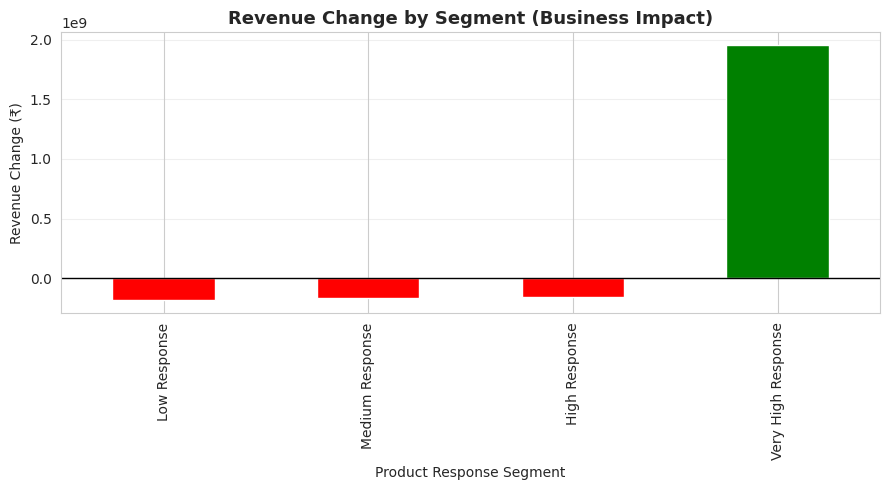

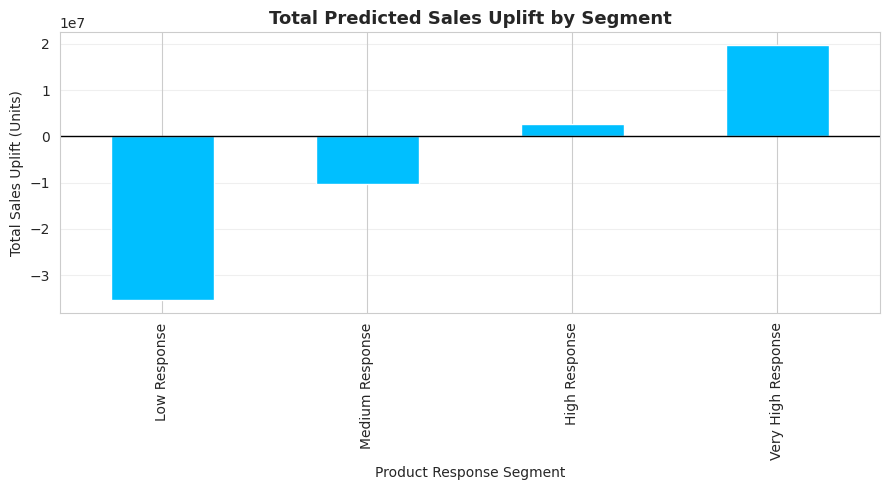


=== BUSINESS IMPACT SEGMENT SUMMARY ===
                    product_count  avg_discount  current_revenue  \
Low Response                    0           NaN      184343900.5   
Medium Response                 0           NaN      168917486.5   
High Response                  23           0.0      171766413.0   
Very High Response           2498           0.0      173267796.0   

                    projected_revenue  revenue_change  total_uplift  \
Low Response             0.000000e+00   -1.843439e+08  -35396533.00   
Medium Response          0.000000e+00   -1.689175e+08  -10328398.75   
High Response            1.292392e+07   -1.588425e+08    2658478.25   
Very High Response       2.129069e+09    1.955801e+09   19754218.33   

                    predicted_sales_sum  current_sales_sum  
Low Response                       0.00          3456750.0  
Medium Response                    0.00          3020000.0  
High Response                 206217.14          3531150.0  
Very High Response

In [26]:
# =============================================================================
# BUSINESS IMPACT VISUALIZATION & EXECUTIVE INSIGHTS
# =============================================================================

import matplotlib.pyplot as plt

# --- Merge summaries from previous analysis ---
summary_table = revenue_comparison.copy()
summary_table['product_count'] = segment_summary['product_count']
summary_table['avg_discount'] = segment_summary['avg_discount']
summary_table['total_uplift'] = segment_summary['total_uplift']
summary_table['predicted_sales_sum'] = segment_summary['predicted_sales_sum']
summary_table['current_sales_sum'] = segment_summary['current_sales_sum']

# Reorder for consistent display (optional)
summary_table = summary_table.reindex(['Low Response', 'Medium Response', 'High Response', 'Very High Response'])

# --- 1. Bar Chart: Revenue Change by Segment ---
plt.figure(figsize=(9, 5))
colors = ['red' if x < 0 else 'green' for x in summary_table['revenue_change']]
summary_table['revenue_change'].plot(kind='bar', color=colors)
plt.title('Revenue Change by Segment (Business Impact)', fontsize=13, fontweight='bold')
plt.xlabel('Product Response Segment')
plt.ylabel('Revenue Change (₹)')
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2. Bar Chart: Total Predicted Uplift by Segment ---
plt.figure(figsize=(9, 5))
summary_table['total_uplift'].plot(kind='bar', color='deepskyblue')
plt.title('Total Predicted Sales Uplift by Segment', fontsize=13, fontweight='bold')
plt.xlabel('Product Response Segment')
plt.ylabel('Total Sales Uplift (Units)')
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 3. Executive-friendly Summary Table ---
display_cols = [
    'product_count', 'avg_discount', 'current_revenue', 'projected_revenue',
    'revenue_change', 'total_uplift', 'predicted_sales_sum', 'current_sales_sum'
]
print("\n=== BUSINESS IMPACT SEGMENT SUMMARY ===")
print(summary_table[display_cols].round(2))